# Electron-Photon (Classical)

This notebook trains and evaluates classical baselines for the electron-photon classification task.
You can find information about the dataset at https://arxiv.org/abs/1807.11916.

In [1]:
import jax
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')  # Ensure TF does not see GPU and grab all GPU memory.
tf.random.set_seed(42)  # For reproducibility.

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_electron_photon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-11-03 02:56:20.726028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 02:56:20.726058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 02:56:20.726084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 02:56:23.933704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U cirq`` to enable related functionality in translation module


The models are trained using the following devices:

In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-40GB


Let's check how many samples the dataset has, the shape of the input data, and how one sample looks like.

Cardinalities (train, val, test): 439200 48800 10000
(32, 32, 2)


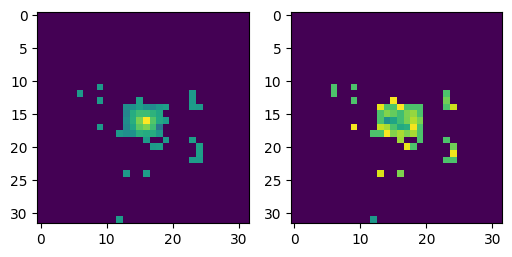

In [3]:
ep_train_dataloader, ep_val_dataloader, ep_test_dataloader = get_electron_photon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(ep_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

Next, we train a big ViT that obtains a good AUC score on the test set (hyperparameters found by random hyperparameter search). Note however that this model size is too big to be replicated on a quantum computer currently.

In [4]:
model = VisionTransformer(num_classes=2, patch_size=8, hidden_size=64, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=32)
train_and_evaluate(model, ep_train_dataloader, ep_val_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 93890


Epoch  50/50: 100%|██████████| 1715/1715 [00:10<00:00, 156.36batch/s, Loss = 0.5493, AUC = 79.38%]


Total training time = 562.15s, best validation AUC = 79.41% at epoch 25


Testing: 100%|██████████| 39/39 [00:01<00:00, 23.25batch/s, Loss = 0.5541, AUC = 79.10%] 


(Array(0.55410224, dtype=float32),
 79.09885959256457,
 array([0.        , 0.        , 0.        , ..., 0.99837695, 0.99837695,
        1.        ]),
 array([0.00000000e+00, 1.97823937e-04, 7.31948566e-03, ...,
        9.99802176e-01, 1.00000000e+00, 1.00000000e+00]))

Now let's train a smaller model which could be run on a quantum computer. Note that the number of parameters is much smaller.

In [5]:
model = VisionTransformer(num_classes=2, patch_size=8, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4)
train_and_evaluate(model, ep_train_dataloader, ep_val_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 2778


Epoch  50/50: 100%|██████████| 1715/1715 [00:10<00:00, 160.96batch/s, Loss = 0.5752, AUC = 76.75%]


Total training time = 519.98s, best validation AUC = 76.79% at epoch 26


Testing: 100%|██████████| 39/39 [00:01<00:00, 37.74batch/s, Loss = 0.5802, AUC = 76.50%] 


(Array(0.58024114, dtype=float32),
 76.49524534241823,
 array([0.        , 0.        , 0.        , ..., 0.99959424, 0.99959424,
        1.        ]),
 array([0.00000000e+00, 1.97823937e-04, 6.33036597e-03, ...,
        9.99802176e-01, 1.00000000e+00, 1.00000000e+00]))